# <center>Analysis of Contribution Through Issues, Forks, and Pull Requests</center>
<center>Nicholas Alonzo</center>  

In [1]:
import re
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=13)

db = sql.connect('github.db')
c = db.cursor()

## Forks and Pull Requests: Characteristics and Successful Merges

### 1. Are pull requests typically open by core contributors or external contributors?

In [2]:
# This query selects the repo ids from where the pull request is coming from and going to
prs_query = """
SELECT to_repo_id,
       from_repo_id
  FROM pull_request_events
 WHERE [action] = 'opened' AND 
       to_repo_id IN (
           SELECT repo_id
             FROM repos
            WHERE forked_from IS NULL
       );
"""
prs = pd.read_sql(prs_query, db)

In [3]:
# Now we can get a percentage 
core_count = prs[prs['from_repo_id'] == prs['to_repo_id']].shape[0]
core_percent = 1.0 * core_count / prs.shape[0]

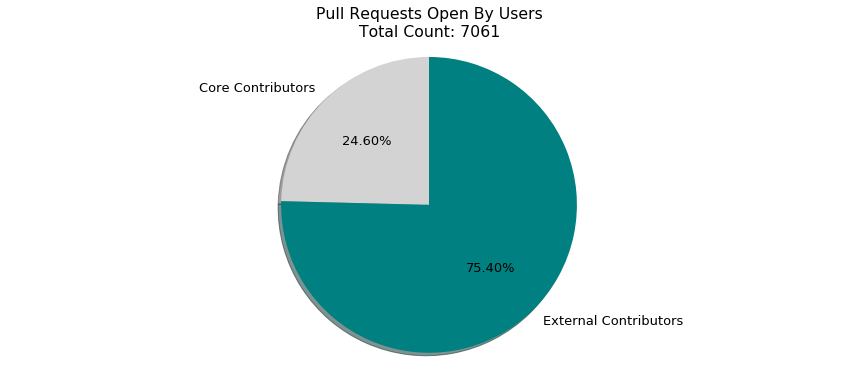

In [4]:
labels = ['Core Contributors','External Contributors']
sizes = [core_percent, 1 - core_percent]
plt.figure(figsize=(15, 6))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', shadow=True, 
        startangle=90, colors=['lightgrey', 'teal'])
plt.axis('equal')
plt.title('Pull Requests Open By Users\nTotal Count: %s' % prs.shape[0])
plt.show()

### 2. What percentage of forks per repo become pull requests? 

In [5]:
# Here we group by the root repo id and count the number of forks
forks_query = """
SELECT forked_from AS repo_id,
       COUNT(repo_id) AS fork_counts
  FROM fork_events
 WHERE forked_from IN (
           SELECT repo_id
             FROM repos
            WHERE forked_from IS NULL
       )
 GROUP BY forked_from;
"""
forks = pd.read_sql(forks_query, db)

In [6]:
# Here we group by the root repo id and count the number of pull 
# requests opened by users who forked the repo. We account for
# the possibility that users can clone then make a pull request.
pull_requests_query = """
SELECT to_repo_id AS repo_id,
       COUNT(DISTINCT (from_repo_id) ) AS pull_request_counts
  FROM pull_request_events
 WHERE [action] = 'opened' AND 
       to_repo_id <> from_repo_id AND 
       to_repo_id IN (
           SELECT repo_id
             FROM repos
            WHERE forked_from IS NULL
       )
AND 
       from_repo_id IN (
           SELECT repo_id
             FROM fork_events
            WHERE forked_from IN (
                      SELECT repo_id
                        FROM repos
                       WHERE forked_from IS NULL
                  )
       )
 GROUP BY to_repo_id;
"""
pull_requests = pd.read_sql(pull_requests_query, db)

In [7]:
# Now we can merge the data frames and calculate the percent of 
# forks becoming and not becoming pull requests
forks_prs = pd.merge(forks, pull_requests, how='left', on='repo_id')

forks_prs['forks_to_prs'] = 100.0 * (forks_prs['pull_request_counts'] / forks_prs['fork_counts'])

In [12]:
# Now we can plot the percent
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8, 6))
plt.hist(forks_prs['forks_to_prs'], bins=20, facecolor='green', alpha=0.75, edgecolor='black')
plt.xlabel('Percent That Become Pull Requests')
plt.ylabel('Number of Forks')
plt.title('Percentage of Forks Per Rep\n That Become Pull Requests')
fig.text(0.5, 0.008, 'Figure 5: Majortiy of forks don\'t contribute back to projects', 
         ha='center', size='large', weight='bold')
plt.grid(True)
# plt.show()
plt.savefig("Fig5.png", dpi=600)

### 3. How long does it take for a fork to become a pull request?

In [13]:
# Here we simply select the root repo id, forked repo id, and the day it was forked
# We keep in mind that this table may have forks from forks, so we make sure that 
# the forked_from field is of the root repos
forks_query = """
SELECT forked_from,
       repo_id,
       date_forked
  FROM fork_events
 WHERE forked_from IN (
           SELECT repo_id
             FROM repos
            WHERE forked_from IS NULL
       );
"""
forks = pd.read_sql(forks_query, db)

In [14]:
# Here we select the root repo, its fork, and the first time the fork made an 
# open pull request. We account for the possibility that users can clone 
# then make a pull request and also that the pull request is not of the same 
# repo under a different branch
pull_requests_query = """
SELECT to_repo_id AS forked_from,
       from_repo_id AS repo_id,
       MIN(action_date) AS pull_request_opened
  FROM pull_request_events
 WHERE [action] = 'opened' AND 
       to_repo_id <> from_repo_id AND 
       to_repo_id IN (
           SELECT repo_id
             FROM repos
            WHERE forked_from IS NULL
       )
AND 
       from_repo_id IN (
           SELECT repo_id
             FROM fork_events
            WHERE forked_from IN (
                      SELECT repo_id
                        FROM repos
                       WHERE forked_from IS NULL
                  )
       )
 GROUP BY to_repo_id,
          from_repo_id;
"""
pull_requests = pd.read_sql(pull_requests_query, db)

In [15]:
# We can now merge the data frames; calculate and plot the date difference
prs_forks = pd.merge(pull_requests, forks, how='left', on=['forked_from', 'repo_id'])

prs_forks['date_diff'] = (pd.to_datetime(prs_forks['pull_request_opened']) - 
                          pd.to_datetime(prs_forks['date_forked'])) / np.timedelta64(1, 'D')

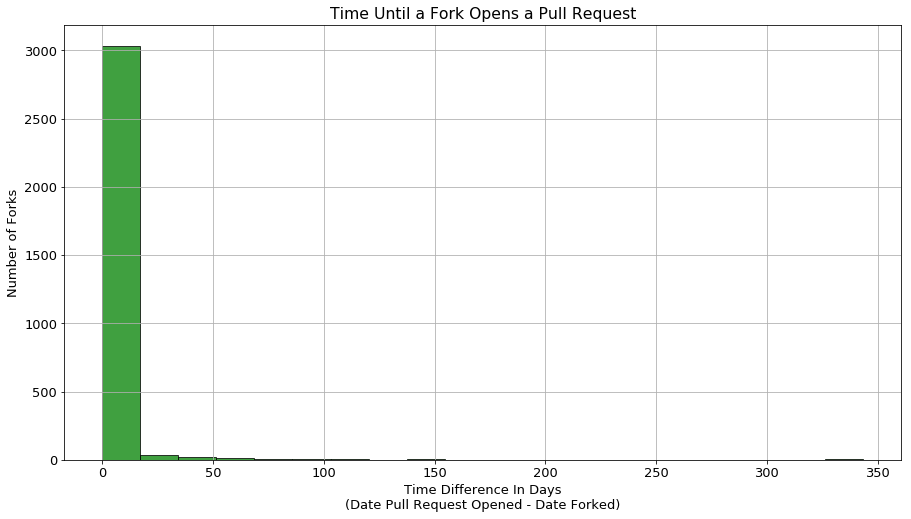

In [17]:
plt.figure(figsize=(15, 8))
plt.hist(prs_forks['date_diff'], bins=20, facecolor='green', alpha=0.75, edgecolor='black')
plt.title('Time Until a Fork Opens a Pull Request')
plt.ylabel('Number of Forks')
plt.xlabel('Time Difference In Days\n(Date Pull Request Opened - Date Forked)')
plt.grid(True)
plt.show()

Here we can see that an exremely large portion of pull request are made in less than a day before a fork is made. However let's take a smaller subset of the data so we can see closer.

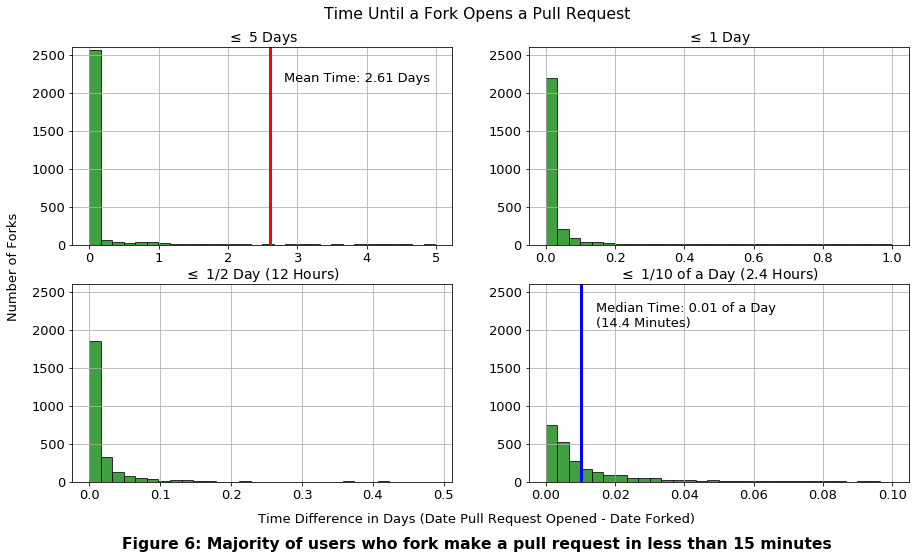

In [43]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.ylim(ymax = 2600, ymin = 0)
plt.hist(prs_forks['date_diff'][prs_forks['date_diff'] <= 5], bins=30, 
         facecolor='green', alpha=0.75, edgecolor='black')
plt.axvline(x=prs_forks['date_diff'].mean(), color='red', linewidth=3)
plt.text(prs_forks['date_diff'].mean() + 0.2, 2150, 
         'Mean Time: %s Days' % round(prs_forks['date_diff'].mean(), 2))
plt.title(r'$\leq$ 5 Days', fontsize = 14)
plt.grid(True)

plt.subplot(2, 2, 2)
plt.ylim(ymax = 2600, ymin = 0)
plt.hist(prs_forks['date_diff'][prs_forks['date_diff'] <= 1], bins=30, 
         facecolor='green', alpha=0.75, edgecolor='black')
plt.title(r'$\leq$ 1 Day', fontsize = 14)
plt.grid(True)

plt.subplot(2, 2, 3)
plt.ylim(ymax = 2600, ymin = 0)
plt.hist(prs_forks['date_diff'][prs_forks['date_diff'] <= 0.5], bins=30, 
         facecolor='green', alpha=0.75, edgecolor='black')
plt.title(r'$\leq$ 1/2 Day (12 Hours)', fontsize = 14)
plt.grid(True)

plt.subplot(2, 2, 4)
plt.ylim(ymax = 2600, ymin = 0)
plt.hist(prs_forks['date_diff'][prs_forks['date_diff'] <= 0.1], bins=30, 
         facecolor='green', alpha=0.75, edgecolor='black')
plt.axvline(x=prs_forks['date_diff'].median(), color='blue', linewidth=3)
plt.text(prs_forks['date_diff'].median() + 0.0045, 2050, 
         'Median Time: %s of a Day\n(14.4 Minutes)' % round(prs_forks['date_diff'].median(), 2))
plt.title(r'$\leq$ 1/10 of a Day (2.4 Hours)', fontsize = 14)
plt.grid(True)

fig.text(0.5, 0.055, 'Time Difference in Days (Date Pull Request Opened - Date Forked)', ha='center')
fig.text(0.5, 0.009, 'Figure 6: Majority of users who fork make a pull request in less than 15 minutes', 
         ha='center', size='large', weight='bold')
fig.text(0.065, 0.5, 'Number of Forks', va='center', rotation='vertical')
plt.suptitle('Time Until a Fork Opens a Pull Request', y=0.95)
plt.show()
# plt.savefig("Fig6.png", dpi=600)

### 4. What percent of pull requests from forks are merged?

In [34]:
pull_requests_query2 = """
SELECT to_repo_id,
       from_repo_id,
       merged
  FROM pull_request_events
 WHERE [action] = 'closed' AND 
       from_repo_id <> 'NULL' AND 
       to_repo_id IN (
           SELECT repo_id
             FROM repos
            WHERE forked_from IS NULL
       )
AND 
       from_repo_id IN (
           SELECT repo_id
             FROM fork_events
            WHERE forked_from IN (
                      SELECT repo_id
                        FROM repos
                       WHERE forked_from IS NULL
                  )
       );
"""
pull_requests2 = pd.read_sql(pull_requests_query2, db)

In [35]:
# Now we can get a percentage 
merge_count = pull_requests2[pull_requests2['merged'] == 1].shape[0]
merge_percent = 1.0 * merge_count / pull_requests2.shape[0]

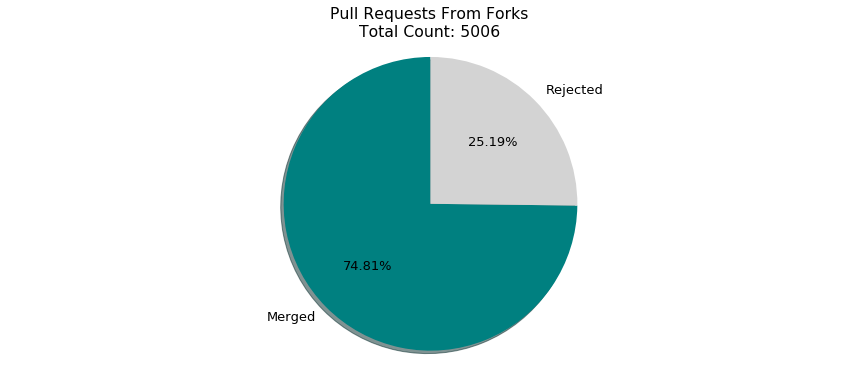

In [37]:
plt.figure(figsize=(15, 6))
labels2 = ['Merged', 'Rejected']
sizes2 = [merge_percent, 1 - merge_percent]
plt.pie(sizes2, labels=labels2, autopct='%1.2f%%', shadow=True, startangle=90, colors=['teal', 'lightgrey'])
plt.axis('equal')
plt.title('Pull Requests From Forks\nTotal Count: %s' % pull_requests2.shape[0])
plt.show()

Note external contributors are also those who may clone and then contribute back to the repo. We can see the majority of these contributions come from external help, which is expected. It shows that core contributors are accepting some kind of change to their repo almost 75% of the time.

### 5. How quickly are pull requests from forks merged?

In [38]:
query1 = """
SELECT pull_request_id,
       to_repo_id,
       from_repo_id,
       date_merged
  FROM pull_request_events
 WHERE [action] = 'closed' AND 
       merged = 1 AND 
       from_repo_id <> 'NULL' AND 
       to_repo_id IN (
           SELECT repo_id
             FROM repos
            WHERE forked_from IS NULL
       )
AND 
       from_repo_id IN (
           SELECT repo_id
             FROM fork_events
            WHERE forked_from IN (
                      SELECT repo_id
                        FROM repos
                       WHERE forked_from IS NULL
                  )
       );
"""
prs = pd.read_sql(query1, db)

In [39]:
query2 = """
SELECT pull_request_id,
       to_repo_id,
       from_repo_id,
       action_date AS date_opened
  FROM pull_request_events
 WHERE [action] = 'opened' AND
       to_repo_id IN (
           SELECT repo_id
             FROM repos
            WHERE forked_from IS NULL
       )
AND 
       from_repo_id IN (
           SELECT repo_id
             FROM fork_events
            WHERE forked_from IN (
                      SELECT repo_id
                        FROM repos
                       WHERE forked_from IS NULL
                  )
       );
"""
prs2 = pd.read_sql(query2, db)

In [40]:
# We can now merge the data frames; calculate and plot the date difference
prs_comb = pd.merge(prs, prs2, how='left', on=['pull_request_id', 'to_repo_id', 'from_repo_id'])

prs_comb = prs_comb.dropna(axis=0, how='any')

prs_comb['date_diff'] = (pd.to_datetime(prs_comb['date_merged']) - 
                          pd.to_datetime(prs_comb['date_opened'])) / np.timedelta64(1, 'D')

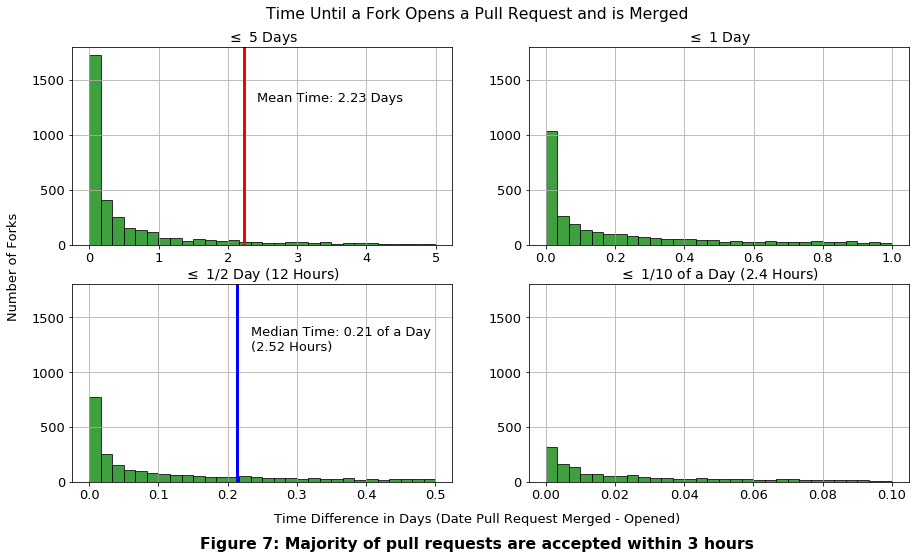

In [46]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.ylim(ymax = 1800, ymin = 0)
plt.hist(prs_comb['date_diff'][prs_comb['date_diff'] <= 5], bins=30, 
         facecolor='green', alpha=0.75, edgecolor='black')
plt.axvline(x=prs_comb['date_diff'].mean(), color='red', linewidth=3)
plt.text(prs_comb['date_diff'].mean() + 0.2, 1300, 
         'Mean Time: %s Days' % round(prs_comb['date_diff'].mean(), 2))
plt.title(r'$\leq$ 5 Days', fontsize = 14)
plt.grid(True)

plt.subplot(2, 2, 2)
plt.ylim(ymax = 1800, ymin = 0)
plt.hist(prs_comb['date_diff'][prs_comb['date_diff'] <= 1], bins=30, 
         facecolor='green', alpha=0.75, edgecolor='black')
plt.title(r'$\leq$ 1 Day', fontsize = 14)
plt.grid(True)

plt.subplot(2, 2, 3)
plt.ylim(ymax = 1800, ymin = 0)
plt.hist(prs_comb['date_diff'][prs_comb['date_diff'] <= 0.5], bins=30, 
         facecolor='green', alpha=0.75, edgecolor='black')
plt.axvline(x=prs_comb['date_diff'].median(), color='blue', linewidth=3)
plt.text(prs_comb['date_diff'].median() + 0.02, 1200, 
         'Median Time: %s of a Day\n(2.52 Hours)' % round(prs_comb['date_diff'].median(), 2))
plt.title(r'$\leq$ 1/2 Day (12 Hours)', fontsize = 14)
plt.grid(True)

plt.subplot(2, 2, 4)
plt.ylim(ymax = 1800, ymin = 0)
plt.hist(prs_comb['date_diff'][prs_comb['date_diff'] <= 0.1], bins=30, 
         facecolor='green', alpha=0.75, edgecolor='black')
plt.title(r'$\leq$ 1/10 of a Day (2.4 Hours)', fontsize = 14)
plt.grid(True)

fig.text(0.5, 0.055, 'Time Difference in Days (Date Pull Request Merged - Opened)', ha='center')
fig.text(0.5, 0.009, 'Figure 7: Majority of pull requests are accepted within 3 hours', 
         ha='center', size='large', weight='bold')
fig.text(0.065, 0.5, 'Number of Forks', va='center', rotation='vertical')
plt.suptitle('Time Until a Fork Opens a Pull Request and is Merged', y=0.95)
plt.show()
# plt.savefig("Fig7.png", dpi=600)

## Issues and Pull Requests

### 1. What percentage of pull requests attempt to close referenced issues?

[Closing Issues via Pull Requests](https://help.github.com/articles/closing-issues-via-commit-messages/)

In [47]:
# Select all pull requests
pr_query = """
SELECT pr1.to_repo_id AS repo_id,
       pr1.from_repo_id,
       pr1.pull_request_id AS pr_id,
       pr1.pull_request_number AS pr_number,
       pr1.title AS pr_title,
       pr1.description AS pr_description,
       pr1.url AS pr_url,
       pr2.action_date AS date_pr_opened,
       pr1.action_date AS date_pr_closed,
       pr1.merged,
       pr1.date_merged AS date_pr_merged,
       pr2.from_user_id AS pr_opened_by
  FROM pull_request_events AS pr1
       LEFT JOIN
       pull_request_events AS pr2 ON (pr1.to_repo_id = pr2.to_repo_id AND 
                                      pr1.pull_request_id = pr2.pull_request_id) 
 WHERE pr2.[action] = 'opened' AND 
       pr1.[action] = 'closed' AND 
       pr1.from_repo_id <> 'NULL' AND 
       pr1.to_repo_id IN (
           SELECT repo_id
             FROM repos
            WHERE forked_from IS NULL
       );
"""
pull_requests = pd.read_sql(pr_query, db)

In [48]:
print 'Number of rows', pull_requests.shape[0]
pull_requests.head(n=2)

Number of rows 6682


,repo_id,from_repo_id,pr_id,pr_number,pr_title,pr_description,pr_url,date_pr_opened,date_pr_closed,merged,date_pr_merged,pr_opened_by
0,49010787,49147100,55233273,17,Markdown formatting and typos,The spaces after headers are rules from [markd...,https://github.com/mhinz/vim-galore/pull/17,2016-01-06 16:36:30,2016-01-06 18:04:45,1,2016-01-06 18:04:44,609213
1,49010787,49199940,55326206,18,Correct spelling error (everytime->every time),,https://github.com/mhinz/vim-galore/pull/18,2016-01-07 11:13:09,2016-01-07 11:15:41,0,None,132421


#### Searching for issue references in the pull request title and description

In [49]:
# Closes an issue if the following patterns are in the description and the pull request is merged
key_words = '((close|closes|closed|fix|fixes|fixed|resolve|resolves|resolved)'

rx1 = ' https://github.com/[A-Za-z]+/[A-Za-z]+#[0-9]+/issues/[0-9]+)' 
rx2 = ' #[0-9]+)' 
rx3 = ' GH-[0-9]+)' 

issue_rx = key_words+rx1 +'|'+ key_words+rx2 +'|'+ key_words+rx3

In [50]:
# Now use issue_rx on the titles and descriptions of the pull requests
ref_issues1 = pull_requests[pull_requests['pr_title'].str.contains(issue_rx, case=False, na=False)]
ref_issues2 = pull_requests[pull_requests['pr_description'].str.contains(issue_rx, case=False, na=False)]
ref_issues = pd.concat([ref_issues1, ref_issues2])
ref_issues = ref_issues.reset_index(drop=True)

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app
/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  app.launch_new_instance()


In [51]:
print 'Number of rows', ref_issues.shape[0], 'out of', pull_requests.shape[0]
ref_issues.head(n=2)

Number of rows 666 out of 6682


,repo_id,from_repo_id,pr_id,pr_number,pr_title,pr_description,pr_url,date_pr_opened,date_pr_closed,merged,date_pr_merged,pr_opened_by
0,51769689,51769689,60213414,31,fix #30 - make hiding markdown helpers more sp...,This is more specific so it doesn't hide the c...,https://github.com/sindresorhus/refined-github...,2016-02-22 17:54:42,2016-02-23 03:42:44,1,2016-02-23 03:42:43,170270
1,51769689,53802558,62681071,78,Add a copy button next to the branch name. Clo...,See #77 for details.\r\n\r\nI'm not sure about...,https://github.com/sindresorhus/refined-github...,2016-03-13 19:52:40,2016-03-31 09:04:52,0,None,1108173


In [52]:
# now extract the patterns
ref_issues_matches1 = ref_issues['pr_title'].str.extractall(issue_rx, flags=re.IGNORECASE)
ref_issues_matches2 = ref_issues['pr_description'].str.extractall(issue_rx, flags=re.IGNORECASE)
ref_issues_matches = pd.concat([ref_issues_matches1, ref_issues_matches2])

ref_issues_matches.head(n=3)

,,0,1,2,3,4,5
,match,,,,,,
0,0,NaN,NaN,fix #30,fix,NaN,NaN
1,0,NaN,NaN,Closes #77,Closes,NaN,NaN
2,0,NaN,NaN,Closes #84,Closes,NaN,NaN


#### Extracting the issue numbers from the matches

In [53]:
D = {}
# extract issue numbers from matches by linking the pull request id
for idx, row in ref_issues_matches.iterrows():
    
    # turn the row into a list
    match_groups = map(str, list(row))
    
    # use index of ref_issues_mathces to index ref_issues and get pr_id
    pr_id = int( ref_issues['pr_id'].iloc[ [idx[0]] ] )
    
    # extract only the issue number; append if there are multiple issues; remove duplicates
    for number in match_groups:
        issue_number = filter(str.isdigit, number)
        if issue_number:
            if pr_id in D:
                D[pr_id].append(issue_number)
                D[pr_id] = list(set(D[pr_id]))
            else:
                D[pr_id] = [issue_number]
        else:
            pass

# Now map the issues referenced from the pull request
ref_issues['issues_referenced'] = ref_issues['pr_id'].map(D)
ref_issues.head(n=2)

,repo_id,from_repo_id,pr_id,pr_number,pr_title,pr_description,pr_url,date_pr_opened,date_pr_closed,merged,date_pr_merged,pr_opened_by,issues_referenced
0,51769689,51769689,60213414,31,fix #30 - make hiding markdown helpers more sp...,This is more specific so it doesn't hide the c...,https://github.com/sindresorhus/refined-github...,2016-02-22 17:54:42,2016-02-23 03:42:44,1,2016-02-23 03:42:43,170270,[30]
1,51769689,53802558,62681071,78,Add a copy button next to the branch name. Clo...,See #77 for details.\r\n\r\nI'm not sure about...,https://github.com/sindresorhus/refined-github...,2016-03-13 19:52:40,2016-03-31 09:04:52,0,None,1108173,[77]


#### Parameterized queries on the issues referenced from the pull requests

In [54]:
# In order to answer the various questions about the refernced issues, 
# a LEFT JOIN is done on the same table to select the most recent date 
# the issue was closed along with the labels that may have been added 
# before it was closed (something we don't have data WHEN it was changed)

D = {}; DFs = []
for idx, row in ref_issues.iterrows():

    issue_numbers = ', '.join(row.issues_referenced)

    query = """
    SELECT i1.repo_id,
           i1.issue_id,
           i1.issue_number,
           i1.title AS issue_title,
           i1.description AS issue_description,
           i1.url AS issue_url,
           i2.labels AS issue_labels,
           i1.date_created AS date_issue_opened,
           i2.date_issue_closed,
           user_id AS issue_opened_by
      FROM issues_events AS i1
           LEFT JOIN
           (
               SELECT repo_id,
                      issue_id,
                      labels,
                      MAX(date_created) AS date_issue_closed
                 FROM issues_events
                WHERE [action] = 'closed'
                GROUP BY repo_id,
                         issue_id,
                         labels
           )
           AS i2 ON (i1.repo_id = i2.repo_id AND 
                     i1.issue_id = i2.issue_id) 
     WHERE i1.repo_id = %s AND 
           i1.[action] = 'opened' AND 
           i1.issue_number IN (%s);
     """ % (row.repo_id, issue_numbers)
    
    query_result = pd.read_sql(query, db)
    key = (str(row.repo_id), str(row.pr_id), str(query_result.issue_id))
    
    # Not all issues we will be in the table
    if query_result.empty:
        continue
    elif key not in D:
        D[key] = None
        result = pd.merge(row.to_frame().T, query_result, how='inner', on='repo_id')
        DFs.append(result)
    else:
        continue

pr_issues = pd.concat(DFs, axis=0, ignore_index=True)

print 'Number of rows and cols', pr_issues.shape
pr_issues.head(n=2)

Number of rows and cols (620, 22)


,repo_id,from_repo_id,pr_id,pr_number,pr_title,pr_description,pr_url,date_pr_opened,date_pr_closed,merged,...,issues_referenced,issue_id,issue_number,issue_title,issue_description,issue_url,issue_labels,date_issue_opened,date_issue_closed,issue_opened_by
0,51769689,51769689,60213414,31,fix #30 - make hiding markdown helpers more sp...,This is more specific so it doesn't hide the c...,https://github.com/sindresorhus/refined-github...,2016-02-22 17:54:42,2016-02-23 03:42:44,1,...,[30],135474784,30,tabnav-extra styles remove lines added/deleted...,- This style is [content.css L79-82](https://g...,https://github.com/sindresorhus/refined-github...,,2016-02-22 16:55:18,2016-02-23 03:42:44,270193
1,51769689,53802558,62681071,78,Add a copy button next to the branch name. Clo...,See #77 for details.\r\n\r\nI'm not sure about...,https://github.com/sindresorhus/refined-github...,2016-03-13 19:52:40,2016-03-31 09:04:52,0,...,[77],140316120,77,Easy copy paste of branches and filenames in PR's,I often review a new PR by opening the Pull Re...,https://github.com/sindresorhus/refined-github...,enhancement::has PR::under discussion,2016-03-11 23:17:13,2016-03-31 09:09:06,1108173


Now we have the data we need in the right format to answer the questions

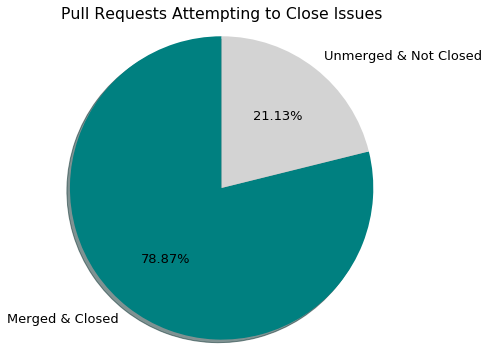

In [55]:
merged = float(1.0 * pr_issues[pr_issues['merged'] == 1].shape[0] / pr_issues.shape[0])
labels = ['Merged & Closed', 'Unmerged & Not Closed']
sizes = [merged, 1-merged]
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90, colors=['teal', 'lightgrey'])
plt.axis('equal')
plt.title('Pull Requests Attempting to Close Issues')
plt.show()

### 2i. What percentage of issues referenced in the pull request were opened by the same user?

In [56]:
same_cond = pr_issues['pr_opened_by'] == pr_issues['issue_opened_by']
percent_same_user = float(1.0 * pr_issues[same_cond].shape[0] / pr_issues.shape[0])

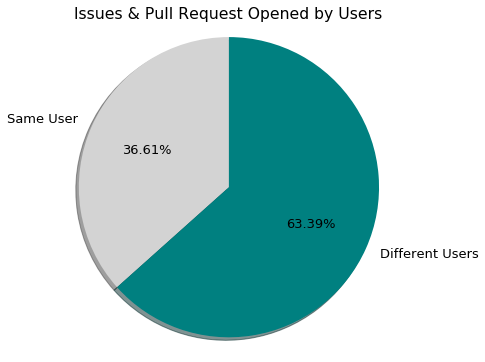

In [57]:
labels = ['Same User','Different Users']
sizes = [percent_same_user, 1 - percent_same_user]
plt.rc('font', size=13)
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90, colors=['lightgrey', 'teal'])
plt.axis('equal')
plt.title('Issues & Pull Request Opened by Users')
plt.show()

This shows that 

### 3. Are referenced issues resolved more by core contributors or external contributors?

In [58]:
# An issue is resolved if the pull request is merged
cond1 = pr_issues['merged'] == 1
# If the repo_id making the pull request is part of the root repo
cond2 = pr_issues['from_repo_id'] == pr_issues['repo_id']

total = pr_issues[cond1].shape[0]
core = 1.0 * pr_issues[cond1 & cond2].shape[0] / total

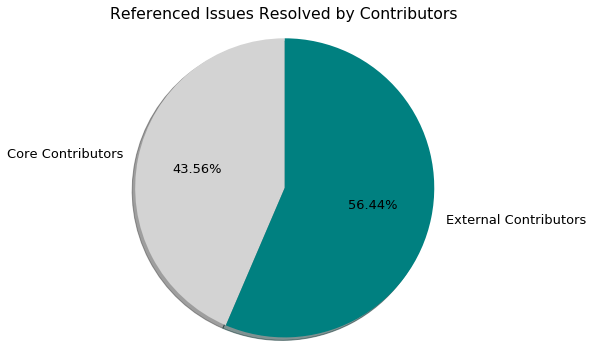

In [59]:
labels = ['Core Contributors','External Contributors']
sizes = [core, 1 - core]
plt.rc('font', size=13)
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90, colors=['lightgrey', 'teal'])
plt.axis('equal')
plt.title('Referenced Issues Resolved by Contributors')
plt.show()

### 4. What is the relative time between when a pull request is opened and references an issue?

In [60]:
pr_issues['opened_diff'] = (pd.to_datetime(pr_issues['date_pr_opened']) 
                            - pd.to_datetime(pr_issues['date_issue_opened'])) / np.timedelta64(1, 'D')
pr_issues['number_diff'] = pr_issues['pr_number'] - pr_issues['issue_number']

In [63]:
# Now we can plot the percent
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.ylim(ymax = 460, ymin = 0)
plt.axvline(x=pr_issues['opened_diff'].mean(), color='red', linewidth=3)
plt.axvline(x=pr_issues['opened_diff'].median(), color='blue', linewidth=3)
plt.hist(pr_issues['opened_diff'], bins=30, facecolor='green', alpha=0.75, edgecolor='black')
plt.title('Time Difference of Pull Request and Issue Opening')
plt.ylabel('Number of Forks')
plt.legend(loc='upper right')
plt.legend(['Mean Difference: %s days' % round(pr_issues['opened_diff'].mean(), 2), 
            'Median Differnece: %s days' % round(pr_issues['opened_diff'].median())])
plt.xlabel('Time Difference in Days\n(Date Pull Request Opened - Date Issue Opened)')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.ylim(ymax = 460, ymin = 0)
plt.axvline(x=pr_issues['number_diff'].mean(), color='red', linewidth=3)
plt.axvline(x=pr_issues['number_diff'].median(), color='blue', linewidth=3)
plt.hist(pr_issues['number_diff'], bins=30, facecolor='green', alpha=0.75, edgecolor='black')
plt.title('Number Difference of Pull Request and Issue')
plt.legend(loc='upper right')
plt.legend(['Mean Difference: %s' % round(pr_issues['number_diff'].mean(), 2) , 
            'Median Difference: %s' % round(pr_issues['number_diff'].median(), 2)])
plt.xlabel('Difference in Number\n(Pull Request Number - Issue Number)')
plt.grid(True)
fig.text(0.5, 0.4, 'Figure 9: Difference of time is short and differnce in number follow closely together', 
         ha='center', size='large', weight='bold')

ax[-1, 0].axis('off')
ax[-1, -1].axis('off')

# plt.savefig("Fig9.png", dpi=600)
plt.show()

## ~ ~ ~ ~ ~ Other analyses ~ ~ ~ ~ ~

In [ ]:
### 2. What percent of fork owners have starred the repo?

owners_watching_query = """
SELECT COUNT(DISTINCT (user_id) ) AS starred_counts
  FROM watch_events
 WHERE user_id IN (
           SELECT user_id
             FROM fork_events
            WHERE forked_from IN (
                      SELECT repo_id
                        FROM repos
                       WHERE forked_from IS NULL
                  )
       );
"""
owners_watching = pd.read_sql(owners_watching_query, db)

# Here we group by the root repo id and count the number of forks
total_forks_query = """
SELECT COUNT(DISTINCT(repo_id) ) AS fork_counts
  FROM fork_events
 WHERE forked_from IN (
           SELECT repo_id
             FROM repos
            WHERE forked_from IS NULL
       );
"""
total_forks = pd.read_sql(total_forks_query, db)

fork_watch =  float(owners_watching['starred_counts'] / total_forks['fork_counts'])
labels = ['Fork & Star','Fork & Don\'t Star']
sizes = [fork_watch, 1 - fork_watch]
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90, colors=['lightgrey', 'teal'])
plt.axis('equal')
plt.title('Percentage of Users Who Fork & Star Repos')
plt.show()

In [2]:
### 1. What does the relationship of opened issues and pull requests look like?
issue_query = """
SELECT repo_id,
       COUNT( * ) AS issue_counts
  FROM issues_events
 WHERE [action] = 'opened' AND 
       repo_id IN (
           SELECT repo_id
             FROM repos
            WHERE forked_from IS NULL
       )
 GROUP BY repo_id;
"""
issues = pd.read_sql(issue_query, db)

pr_query = """
SELECT to_repo_id AS repo_id,
       COUNT( * ) AS pull_request_counts
  FROM pull_request_events
 WHERE [action] = 'opened' AND 
       to_repo_id IN (
           SELECT repo_id
             FROM repos
            WHERE forked_from IS NULL
       )
 GROUP BY repo_id"""
pull_requests = pd.read_sql(pr_query, db)

pr_issues = pd.merge(issues, pull_requests, how='inner', on='repo_id')

plt.figure(figsize=(15, 8))
plt.scatter(pr_issues['issue_counts'], pr_issues['pull_request_counts'], color='darkblue', s=15)
plt.xlabel('Number of Issues')
plt.ylabel('Number of Pull Requests')
plt.title('Issues vs Pull Requests Per Repo')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(pr_issues['issue_counts'], pr_issues['pull_request_counts'], color='darkblue', s=10)
plt.xlabel('Number of Issues\n\nFigure 1: ')
plt.ylabel('Number of Pull Requests')
plt.title('Pull Requests vs Issues')
plt.tight_layout()

In [ ]:
### Helper functions

mimic the split() function in R
def split(DF, grouping):
    """
    DF: pandas DataFrame
    grouping: column name or list of column names to split by
    return: a list of DF's split by the group(s) 
    """
    gb = DF.groupby(grouping)
    split_df = [gb.get_group(x) for x in gb.groups]
    return split_df

def merge_dicts(*dict_args):
    """
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    """
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

## Resources

- https://stackoverflow.com/questions/23691133/split-pandas-dataframe-based-on-groupby
- https://stackoverflow.com/questions/28669482/appending-pandas-dataframes-generated-in-a-for-loop
- https://stackoverflow.com/questions/289680/difference-between-2-dates-in-sqlite
- https://stackoverflow.com/questions/19290762/cant-modify-list-elements-in-a-loop-python
- https://stackoverflow.com/questions/31993186/type-switch-from-int-to-float64-after-merge-creating-error
- https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html


- https://stackoverflow.com/questions/26825729/extract-number-from-string-python
- https://stackoverflow.com/questions/38987/how-to-merge-two-python-dictionaries-in-a-single-expression
- https://stackoverflow.com/questions/14507591/python-dictionary-comprehension
- https://stackoverflow.com/questions/16096627/pandas-select-row-of-data-frame-by-integer-index
- https://stackoverflow.com/questions/3640359/regular-expressions-search-in-list
- https://stackoverflow.com/questions/4502314/python-extracting-a-list-of-sub-strings
- https://stackoverflow.com/questions/9542738/python-find-in-list


- https://stackoverflow.com/questions/13517614/draw-different-color-for-nodes-in-networkx-based-on-their-node-value
- https://stackoverflow.com/questions/32894223/how-to-show-node-name-in-graphs-using-networkx


- https://stackoverflow.com/questions/13316397/matplotlib-animation-no-moviewriters-available/14574894#14574894
- https://stackoverflow.com/questions/23074484/cannot-save-matplotlib-animation-with-ffmpeg
- https://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/

- https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots

- https://stackoverflow.com/questions/24988448/how-to-draw-vertical-lines-on-a-given-plot-in-matplotlib
- https://stackoverflow.com/questions/39050539/adding-multiple-columns-to-pandas-simultaneously

https://stackoverflow.com/questions/18428823/python-matplotlib-less-than-or-equal-to-symbol-in-text
https://stackoverflow.com/questions/22132525/add-column-with-number-of-days-between-dates-in-dataframe-pandas

https://stackoverflow.com/questions/25864695/high-quality-plots-in-matplotlib
https://stackoverflow.com/questions/6774086/why-is-my-xlabel-cut-off-in-my-matplotlib-plot
https://stackoverflow.com/questions/10035446/how-can-i-make-a-blank-subplot-in-matplotlib

## Q1. How many forks occur between an issue's opening and closing period?

In [4]:
# This query finds all the issue ids where there was an opening and closing action for the 
# issue itself. It then inserts the results into a temporary table QUERY1 for later use.
# NOTE: 
# 1. It's likely that some issues will be reopened and then closed again
# 2. For some reason not all issues will be in the DB, perhaps due to pre-processing error?

QUERY1 = '''
CREATE TEMP TABLE QUERY1 AS 
SELECT issue_id
  FROM (
           SELECT repo_id,
                  issue_id,
                  [action]
             FROM issues_events
            WHERE [action] = 'opened'
           UNION
           SELECT repo_id,
                  issue_id,
                  [action]
             FROM issues_events
            WHERE [action] = 'closed'
       )
       AS R1
 WHERE repo_id IN (
           SELECT repo_id
             FROM repos
            WHERE forked_from IS NULL
       )
 GROUP BY repo_id,
          issue_id
HAVING COUNT( * ) = 2;
'''
c.execute(QUERY1)

In [5]:
# This query uses the QUERY1 results to select the number of times that issue appeared MOD 2 = 0
# and inserts the results into a temporary table QUERY2 for later use. Since the only actions in 
# this table are 'opened', 'closed', and 'reopened'. MOD 2 = 0 means there was a pair of opening
# and closing actions that occured.

QUERY2 =  '''
CREATE TEMP TABLE QUERY2 AS
SELECT issue_id
  FROM issues_events
 WHERE issue_id IN (SELECT issue_id FROM [temp].QUERY1)
 GROUP BY repo_id,
          issue_id
HAVING COUNT( * ) % 2 = 0;
'''
c.execute(QUERY2)

In [6]:
# This query uses the QUERY2 results to select the date the issue was FIRST OPENED and
# inserts the results into a temporary table DT_OPENED for later use.

DT_OPENED = '''
CREATE TEMP TABLE DT_OPENED AS
SELECT repo_id,
       issue_id,
       issue_number,
       MIN(date_created) AS exact_date_opened
  FROM issues_events
 WHERE issue_id IN (SELECT issue_id FROM [temp].QUERY2)
 GROUP BY repo_id,
          issue_id,
          issue_number;
'''
c.execute(DT_OPENED)

In [7]:
# This query uses the QUERY2 results to select the date the issue was LAST CLOSED and
# inserts the results into a temporary table DT_CLOSED for later use.

DT_CLOSED = '''
CREATE TEMP TABLE DT_CLOSED AS
SELECT repo_id,
       issue_id,
       issue_number,
       MAX(date_created) AS exact_date_closed
  FROM issues_events
 WHERE issue_id IN (SELECT issue_id FROM [temp].QUERY2)
 GROUP BY repo_id,
          issue_id,
          issue_number;
'''
c.execute(DT_CLOSED)

In [8]:
# In this query DT_OPENED and DT_CLOSED are used to bring back part of the final DataFrame for analyses
# NOTE: 
# 1. As stated there will be some issues that were reopened and closed once or more
#    so the time between opening and closing may be very wide.
# 2. Selecting the rest of the columns from the issues_events table (title, description, ...) 
#    are the exact values when the issue was LAST CLOSED, hence the LEFT JOIN on DT_CLOSED.

issue_query = '''
SELECT DISTINCT o.*,
       c.exact_date_closed,
       ROUND(ABS(julianday(o.exact_date_opened) - julianday(c.exact_date_closed) ), 2) AS exact_date_diff,
       DATE(o.exact_date_opened) AS date_opened,
       DATE(c.exact_date_closed) AS date_closed,
       ABS(julianday(DATE(o.exact_date_opened) ) - julianday(DATE(c.exact_date_closed) ) ) AS date_diff,
       ie.title,
       ie.description,
       ie.labels,
       ie.url,
       ie.comments_count,
       ie.user_id,
       ie.user_login
  FROM [temp].DT_OPENED AS o
       LEFT JOIN
       [temp].DT_CLOSED AS c ON (o.repo_id = c.repo_id AND 
                                 o.issue_id = c.issue_id) 
       LEFT JOIN
       issues_events AS ie ON (c.repo_id = ie.repo_id AND 
                               c.issue_id = ie.issue_id AND 
                               c.exact_date_closed = ie.date_created)
 ORDER BY o.repo_id,
          o.issue_number;
'''
issues = pd.read_sql(issue_query, db)

In [9]:
print 'Number of rows', issues.shape[0]
issues.head(n=2)

Number of rows 11767


,repo_id,issue_id,issue_number,exact_date_opened,exact_date_closed,exact_date_diff,date_opened,date_closed,date_diff,title,description,labels,url,comments_count,user_id,user_login
0,48933503,130229006,16,2016-02-01 01:57:44,2016-02-14 05:06:52,13.13,2016-02-01,2016-02-14,13.0,Toolbar title sometimes gets cut off with elli...,"Happens randomly, restarting the app always so...",bug::help wanted::high priority,https://github.com/afollestad/polar-dashboard/...,7,6379975,plusCubed
1,48933503,130229075,17,2016-02-01 01:58:17,2016-02-10 17:19:23,9.64,2016-02-01,2016-02-10,9.0,Window insets occasionally not applied,The home FAB sometimes goes under the nav bar....,bug::help wanted::high priority,https://github.com/afollestad/polar-dashboard/...,16,1820165,afollestad


In [10]:
# Drop the temporary tables
c.executescript('''
DROP TABLE [temp].QUERY1; 
DROP TABLE [temp].QUERY2;
DROP TABLE [temp].DT_OPENED;
DROP TABLE [temp].DT_CLOSED;
''')
db.commit()

In [12]:
# Now we can use the issues DataFrame to do parameterized queries to get 
# the number of forks occuring between the issue periods for each repo.

DFs = []
for idx, row in issues.iterrows():
    
    query = """
    SELECT COUNT( * ) AS fork_count
      FROM fork_events
     WHERE forked_from = %s AND
           date_forked BETWEEN '%s' AND '%s';
    """ % (row.repo_id, row.exact_date_opened, row.exact_date_closed)
    
    query_result = pd.read_sql(query, db)
    query_result.insert(0, 'issue_id', row.issue_id)
    query_result.insert(0, 'repo_id', row.repo_id)
    DFs.append(query_result)

forks = pd.concat(DFs, axis=0, ignore_index=True)

In [13]:
print 'Number of rows', forks.shape[0]
forks.head(n=3)

Number of rows 11767


,repo_id,issue_id,fork_count
0,48933503,130229006,20
1,48933503,130229075,18
2,48933503,130232230,1


In [14]:
# Merge issues and forks DataFrame's
issues_forks = pd.merge(issues, forks, how='inner', on=['repo_id', 'issue_id'])

In [15]:
# Now we have the complete DataFrame to do some analyses on
print 'Number of rows', issues_forks.shape[0]
issues_forks.head(n=2)

Number of rows 11767


,repo_id,issue_id,issue_number,exact_date_opened,exact_date_closed,exact_date_diff,date_opened,date_closed,date_diff,title,description,labels,url,comments_count,user_id,user_login,fork_count
0,48933503,130229006,16,2016-02-01 01:57:44,2016-02-14 05:06:52,13.13,2016-02-01,2016-02-14,13.0,Toolbar title sometimes gets cut off with elli...,"Happens randomly, restarting the app always so...",bug::help wanted::high priority,https://github.com/afollestad/polar-dashboard/...,7,6379975,plusCubed,20
1,48933503,130229075,17,2016-02-01 01:58:17,2016-02-10 17:19:23,9.64,2016-02-01,2016-02-10,9.0,Window insets occasionally not applied,The home FAB sometimes goes under the nav bar....,bug::help wanted::high priority,https://github.com/afollestad/polar-dashboard/...,16,1820165,afollestad,18


### Distribution of Issue Period &  Forks Per Issue

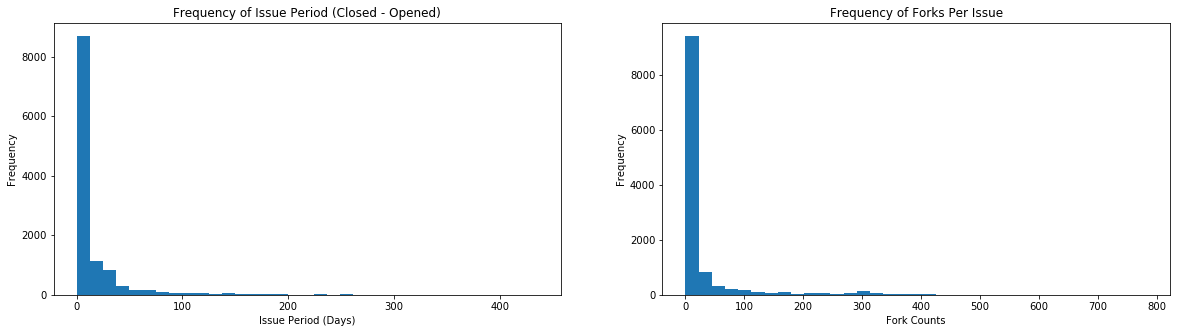

In [16]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(issues_forks['exact_date_diff'], bins=35)
plt.ylabel('Frequency')
plt.xlabel('Issue Period (Days)')
plt.title('Frequency of Issue Period (Closed - Opened)')

plt.subplot(1, 2, 2)
plt.hist(issues_forks['fork_count'], bins=35)
plt.ylabel('Frequency')
plt.xlabel('Fork Counts')
plt.title('Frequency of Forks Per Issue')

plt.show()

It's a little difficult to see, whats going so let's take a look at them together

### Fork Count vs Exact Issue Period

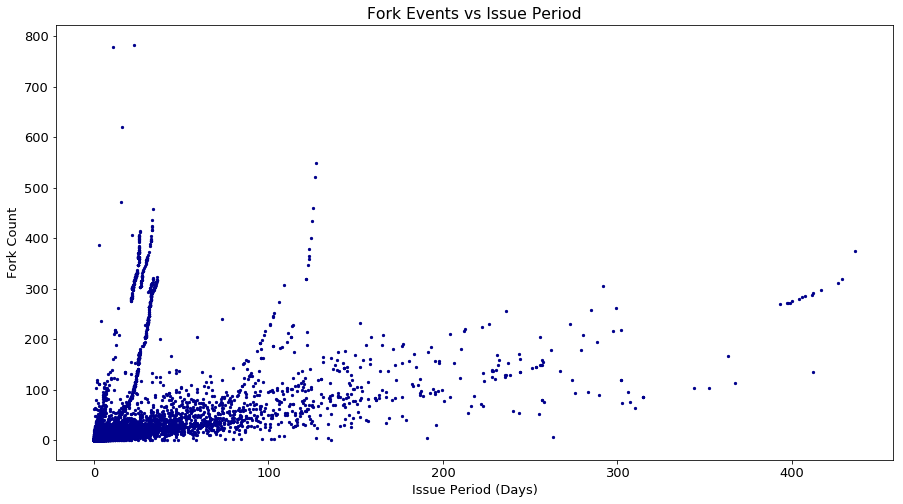

In [17]:
plt.rc('font', size=13)
plt.figure(figsize=(15, 8))
plt.scatter(issues_forks['exact_date_diff'], issues_forks['fork_count'], color='darkblue', s=5)
plt.title('Fork Events vs Issue Period')
plt.xlabel('Issue Period (Days)')
plt.ylabel('Fork Count')
plt.show()

Here we can see some highly correlated patterns spread among both variables. Generally we see a positive correlation among the time a issue is open and the number of forks occuring, however, what is more interesting are issues that were opened for a short amount of time, and high number of forks. We'll look into this, but first lets take a look at a subset to see what kind of association is occuring in the plot.

### Taking a small subset from the plot

In [18]:
fork_cond1 = issues_forks['fork_count'] >= 250
fork_cond2 = issues_forks['fork_count'] <= 450
issue_cond1 = issues_forks['exact_date_diff'] >= 25
issue_cond2 = issues_forks['exact_date_diff'] <= 35

issues_forks_subset = issues_forks[(fork_cond1 & fork_cond2) & (issue_cond1 & issue_cond2)]

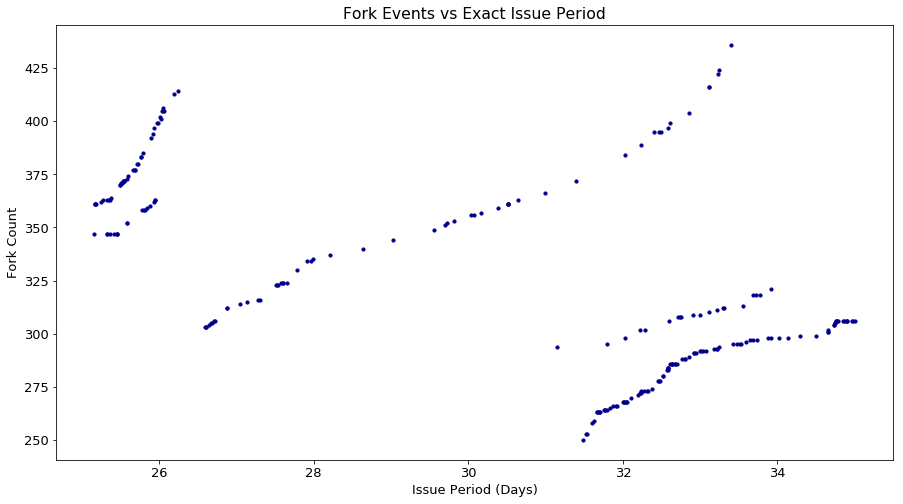

In [19]:
plt.rc('font', size=13)
plt.figure(figsize=(15, 8))
plt.scatter(issues_forks_subset['exact_date_diff'], issues_forks_subset['fork_count'], color='darkblue', s=10)
plt.title('Fork Events vs Exact Issue Period')
plt.xlabel('Issue Period (Days)')
plt.ylabel('Fork Count')
plt.show()

Now we that we have this small subset from the previous plot, let's see the data to see what might be the reason for these associations.

In [20]:
print 'Unique repo ids', issues_forks_subset['repo_id'].unique()
print 'Number of rows', issues_forks_subset.shape[0]
issues_forks_subset.head()

Unique repo ids [63730796]
Number of rows 234


,repo_id,issue_id,issue_number,exact_date_opened,exact_date_closed,exact_date_diff,date_opened,date_closed,date_diff,title,description,labels,url,comments_count,user_id,user_login,fork_count
7362,63730796,166598404,9,2016-07-20 14:41:26,2016-08-15 20:32:10,26.24,2016-07-20,2016-08-15,26.0,Not able to adjust search range or search for ...,This is more of a feature request.\r\nCan you ...,,https://github.com/mchristopher/PokemonGo-Desk...,3,11682773,AVellucci,414
7363,63730796,166618672,10,2016-07-20 16:01:08,2016-08-15 20:31:41,26.19,2016-07-20,2016-08-15,26.0,5 Pokemon of ~50,"Its an amazing project, but it just showed 5 d...",,https://github.com/mchristopher/PokemonGo-Desk...,3,11682773,AVellucci,413
7368,63730796,166658029,16,2016-07-20 19:08:03,2016-08-15 20:32:23,26.06,2016-07-20,2016-08-15,26.0,map not load,I can login but the map is not loading. Only w...,,https://github.com/mchristopher/PokemonGo-Desk...,0,11682773,AVellucci,405
7370,63730796,166660392,18,2016-07-20 19:19:45,2016-08-15 20:32:46,26.05,2016-07-20,2016-08-15,26.0,Permit Own GoogleMaps API,To prevent a blank screen or using an API key ...,,https://github.com/mchristopher/PokemonGo-Desk...,4,11682773,AVellucci,405
7371,63730796,166662277,19,2016-07-20 19:29:02,2016-08-15 20:44:12,26.05,2016-07-20,2016-08-15,26.0,Online / Offline / Unstable Icons,If you cannot contact the login server or the ...,,https://github.com/mchristopher/PokemonGo-Desk...,0,11682773,AVellucci,406


In [21]:
print 'Unique users closing issue', issues_forks_subset['user_login'].unique()

Unique users closing issue [u'AVellucci' u'mchristopher']


After observing this subset we can see that the there is only one repo and 2 users who are closing these issues. More importantly, from looking at the head of the DataFrame, we can see that the issues were open all on the same day and closed all on the same day, one after another leading to the tight correlation in the previous plots. We can also see that the number of comments the issues had when it closed was significantly lower than the time the issue was opened. More than likely, these issues should have been closed much earlier if no activity had been occuring.

Now that we know these kinds of scenarios can occur let's try and look at a set of conditions that we think might have more insight.

## Q2. Mapping pull requests to issues


In [22]:
# Finds repos and closed pull requests regardless of being merging or not from forks 
pr_query = '''
SELECT to_repo_id AS repo_id,
       from_repo_id AS forked_repo_id,
       pull_request_id AS pr_id,
       pull_request_number AS pr_number,
       title AS pr_title,
       description AS pr_description,
       url AS pr_url,
       action_date AS date_pr_closed,
       merged,
       date_merged,
       merged_by_user_id,
       merged_by_user_login
  FROM pull_request_events
 WHERE action = 'closed' AND 
       to_repo_id <> from_repo_id AND 
       repo_id IN (
           SELECT repo_id
             FROM repos
            WHERE forked_from IS NULL
       );
'''
pull_requests = pd.read_sql(pr_query, db)

In [24]:
print 'Number of rows', pull_requests.shape[0]
pull_requests.head(n=2)

Number of rows 5112


,repo_id,forked_repo_id,pr_id,pr_number,pr_title,pr_description,pr_url,date_pr_closed,merged,date_merged,merged_by_user_id,merged_by_user_login
0,49010787,49147100,55233273,17,Markdown formatting and typos,The spaces after headers are rules from [markd...,https://github.com/mhinz/vim-galore/pull/17,2016-01-06 18:04:45,1,2016-01-06 18:04:44,972014,mhinz
1,49010787,49199940,55326206,18,Correct spelling error (everytime->every time),,https://github.com/mhinz/vim-galore/pull/18,2016-01-07 11:15:41,0,None,NULL,NULL


#### Searching for issue references in the pull request description

In [25]:
# Closes the issues exactly if the following patterns are found in the description and the pull request is merged
key_words = '((close|closes|closed|fix|fixes|fixed|resolve|resolves|resolved)'

# issue url; '#' and issue number; GH- and issue number
rx1 = ' https://github.com/[A-Za-z]+/[A-Za-z]+#[0-9]+/issues/[0-9]+)' 
rx2 = ' #[0-9]+)' 
rx3 = ' GH-[0-9]+)' 

# This is another kind of rx, but may refernce a different issue from a different repository
# [A-Za-z]+/[A-Za-z]+#[0-9]+

#### Issue references from merged issues

In [26]:
ref_issues1 = pull_requests[pull_requests['pr_description'].str.contains(key_words+rx1 +'|'+ key_words+rx2, case=False, na=False)]

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if __name__ == '__main__':


In [27]:
# the capitalization matters here in the rgx
ref_issues2 = pull_requests[pull_requests['pr_description'].str.contains(key_words+rx3, na=False)]

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app


In [28]:
ref_issues = pd.concat([ref_issues1, ref_issues2])
ref_issues = ref_issues.reset_index(drop=True)

In [29]:
print 'Number of rows', ref_issues.shape[0], 'out of', pull_requests.shape[0]
ref_issues.head(n=2)

Number of rows 317 out of 5112


,repo_id,forked_repo_id,pr_id,pr_number,pr_title,pr_description,pr_url,date_pr_closed,merged,date_merged,merged_by_user_id,merged_by_user_login
0,51769689,51877331,59570869,12,Add `Releases` tab to the repo page,Closes #8\r\n\r\nI've successfully added a rel...,https://github.com/sindresorhus/refined-github...,2016-02-18 07:46:47,0,None,NULL,NULL
1,51682497,51901680,59603773,6,Use dirname instead of basename,checks if output directory exists\r\n\r\nresol...,https://github.com/jcjohnson/torch-rnn/pull/6,2016-02-17 07:30:30,1,2016-02-17 07:30:29,2718714,jcjohnson


In [30]:
# now extract the patterns
ref_issues_matches = ref_issues['pr_description'].str.extractall(key_words+rx1 +'|'+ key_words+rx2 +'|'+ key_words+rx3, flags=re.IGNORECASE)

In [31]:
print 'Number of rows', ref_issues_matches.shape[0]
ref_issues_matches.head(n=5)

Number of rows 321


,,0,1,2,3,4,5
,match,,,,,,
0,0,NaN,NaN,Closes #8,Closes,NaN,NaN
1,0,NaN,NaN,resolves #5,resolves,NaN,NaN
2,0,NaN,NaN,Fixes #15,Fixes,NaN,NaN
3,0,NaN,NaN,Fixes #2,Fixes,NaN,NaN
4,0,NaN,NaN,Resolves #2,Resolves,NaN,NaN


In [32]:
D = {}
# extract referenced issues from matches by linking pull request id
for idx, row in ref_issues_matches.iterrows():
    
    # turn the row into a list
    match_groups = map(str, list(row))
    
    # use index of referenced issue_mathces to index referenced issues and get pull request id
    pr_id = int( ref_issues['pr_id'].iloc[ [idx[0]] ] )
    
    # extract only the issue number; append if there are multiple issues; remove duplicates
    for number in match_groups:
        issue_number = filter(str.isdigit, number)
        if issue_number:
            if pr_id in D:
                D[pr_id].append(issue_number)
                D[pr_id] = list(set(D[pr_id]))
            else:
                D[pr_id] = [issue_number]
        else:
            pass

In [33]:
# Now map the issues referenced from the pull request
ref_issues['issues_referenced'] = ref_issues['pr_id'].map(D)

In [34]:
ref_issues.head(n=2)

,repo_id,forked_repo_id,pr_id,pr_number,pr_title,pr_description,pr_url,date_pr_closed,merged,date_merged,merged_by_user_id,merged_by_user_login,issues_referenced
0,51769689,51877331,59570869,12,Add `Releases` tab to the repo page,Closes #8\r\n\r\nI've successfully added a rel...,https://github.com/sindresorhus/refined-github...,2016-02-18 07:46:47,0,None,NULL,NULL,[8]
1,51682497,51901680,59603773,6,Use dirname instead of basename,checks if output directory exists\r\n\r\nresol...,https://github.com/jcjohnson/torch-rnn/pull/6,2016-02-17 07:30:30,1,2016-02-17 07:30:29,2718714,jcjohnson,[5]


In [35]:
# Now we can use the referenced issues DataFrame to do parameterized queries to get 
# the information on the issues that were referenced from the pull requests

DFs = []
for idx, row in ref_issues.iterrows():

    issue_numbers = ', '.join(row.issues_referenced)

    query = """
    SELECT repo_id,
           issue_id,
           issue_number,
           title AS issue_title,
           description AS issue_description,
           url AS issue_url,
           labels AS issue_labels,
           date_created AS date_issue_closed,
           user_id AS action_by_user_id,
           user_login AS action_by_user_login
      FROM issues_events
     WHERE repo_id = %s AND action = 'closed' AND
           issue_number IN (%s);
     """ % (row.repo_id, issue_numbers)
    
    query_result = pd.read_sql(query, db)
    
    # not all issues may be in the DB
    if query_result.empty:
        continue
    else:
        result = pd.merge(row.to_frame().T, query_result, how='inner', on='repo_id')
        DFs.append(result)

pr_issues = pd.concat(DFs, axis=0, ignore_index=True)

In [36]:
print 'Number of rows and cols', pr_issues.shape
pr_issues.head(n=3)

Number of rows and cols (326, 22)


,repo_id,forked_repo_id,pr_id,pr_number,pr_title,pr_description,pr_url,date_pr_closed,merged,date_merged,...,issues_referenced,issue_id,issue_number,issue_title,issue_description,issue_url,issue_labels,date_issue_closed,action_by_user_id,action_by_user_login
0,51769689,51877331,59570869,12,Add `Releases` tab to the repo page,Closes #8\r\n\r\nI've successfully added a rel...,https://github.com/sindresorhus/refined-github...,2016-02-18 07:46:47,0,None,...,[8],133921414,8,Add link to releases on every repository page,At the moment you can click to go to the relea...,https://github.com/sindresorhus/refined-github...,enhancement::help wanted,2016-02-18 07:46:47,170270,sindresorhus
1,51682497,51901680,59603773,6,Use dirname instead of basename,checks if output directory exists\r\n\r\nresol...,https://github.com/jcjohnson/torch-rnn/pull/6,2016-02-17 07:30:30,1,2016-02-17 07:30:29,...,[5],134194857,5,Checkpoint saving error when writing to json file,"Hey, this is the error I'm getting when checkp...",https://github.com/jcjohnson/torch-rnn/issues/5,,2016-02-17 07:30:30,2718714,jcjohnson
2,51769689,51954049,59718495,17,Implement like / dislike count,Comments that contain only `+1` or :+1: will b...,https://github.com/sindresorhus/refined-github...,2016-02-23 04:01:36,0,None,...,[15],134246910,15,Hide/Group the contentless comments,"Some comments like `+1` could be removed, or a...",https://github.com/sindresorhus/refined-github...,enhancement::help wanted,2016-02-23 04:01:36,170270,sindresorhus


In [20]:
pr_issues.to_csv('pr_issues.csv')

#### Repo and Fork pair

In [21]:
# Get all the unique repo_id and forked_repo_id pair
repos_forks = pr_issues[['repo_id', 'forked_repo_id']].drop_duplicates()

In [22]:
# Use the unique repo and make a dict for their color and size
unique_repos = list(repos_forks['repo_id'].unique())
unique_repos_col = {x: 'red' for x in unique_repos}
unique_repos_size = {x: 400 for x in unique_repos}

#### Fork and Pull Request pair

In [25]:
# Get all the unique forked_repo_id and pull_request_id pair
forks_pr = pr_issues[['forked_repo_id', 'pr_id']].drop_duplicates()

In [26]:
unique_forks = list(forks_pr['forked_repo_id'].unique())
unique_forks_col = {x: 'green' for x in unique_forks}
unique_forks_size = {x: 150 for x in unique_forks}

#### Pull Request and Issue pair

In [29]:
# Get all the unique pull_request_id and issue_id pair
pr_issues = pr_issues[['pr_id', 'issue_id']].drop_duplicates()

In [31]:
unique_pr = list(pr_issues['pr_id'].unique()) 
unique_pr_col = {x: 'blue' for x in unique_pr}
unique_pr_size = {x: 100 for x in unique_pr}

#### Merge the dictionaries for size and color

In [35]:
cols_dict = merge_dicts(unique_repos_col, unique_forks_col, unique_pr_col)
size_dict = merge_dicts(unique_repos_size, unique_forks_size, unique_pr_size)

#### Create the graph structure 

In [37]:
G = nx.Graph()
G.add_edges_from(map(tuple, repos_forks.values))
G.add_edges_from(map(tuple, forks_pr.values))
G.add_edges_from(map(tuple, pr_issues.values))

In [38]:
cols = [cols_dict.get(node, 'black') for node in G.nodes()]
size = [size_dict.get(node, 30) for node in G.nodes()]

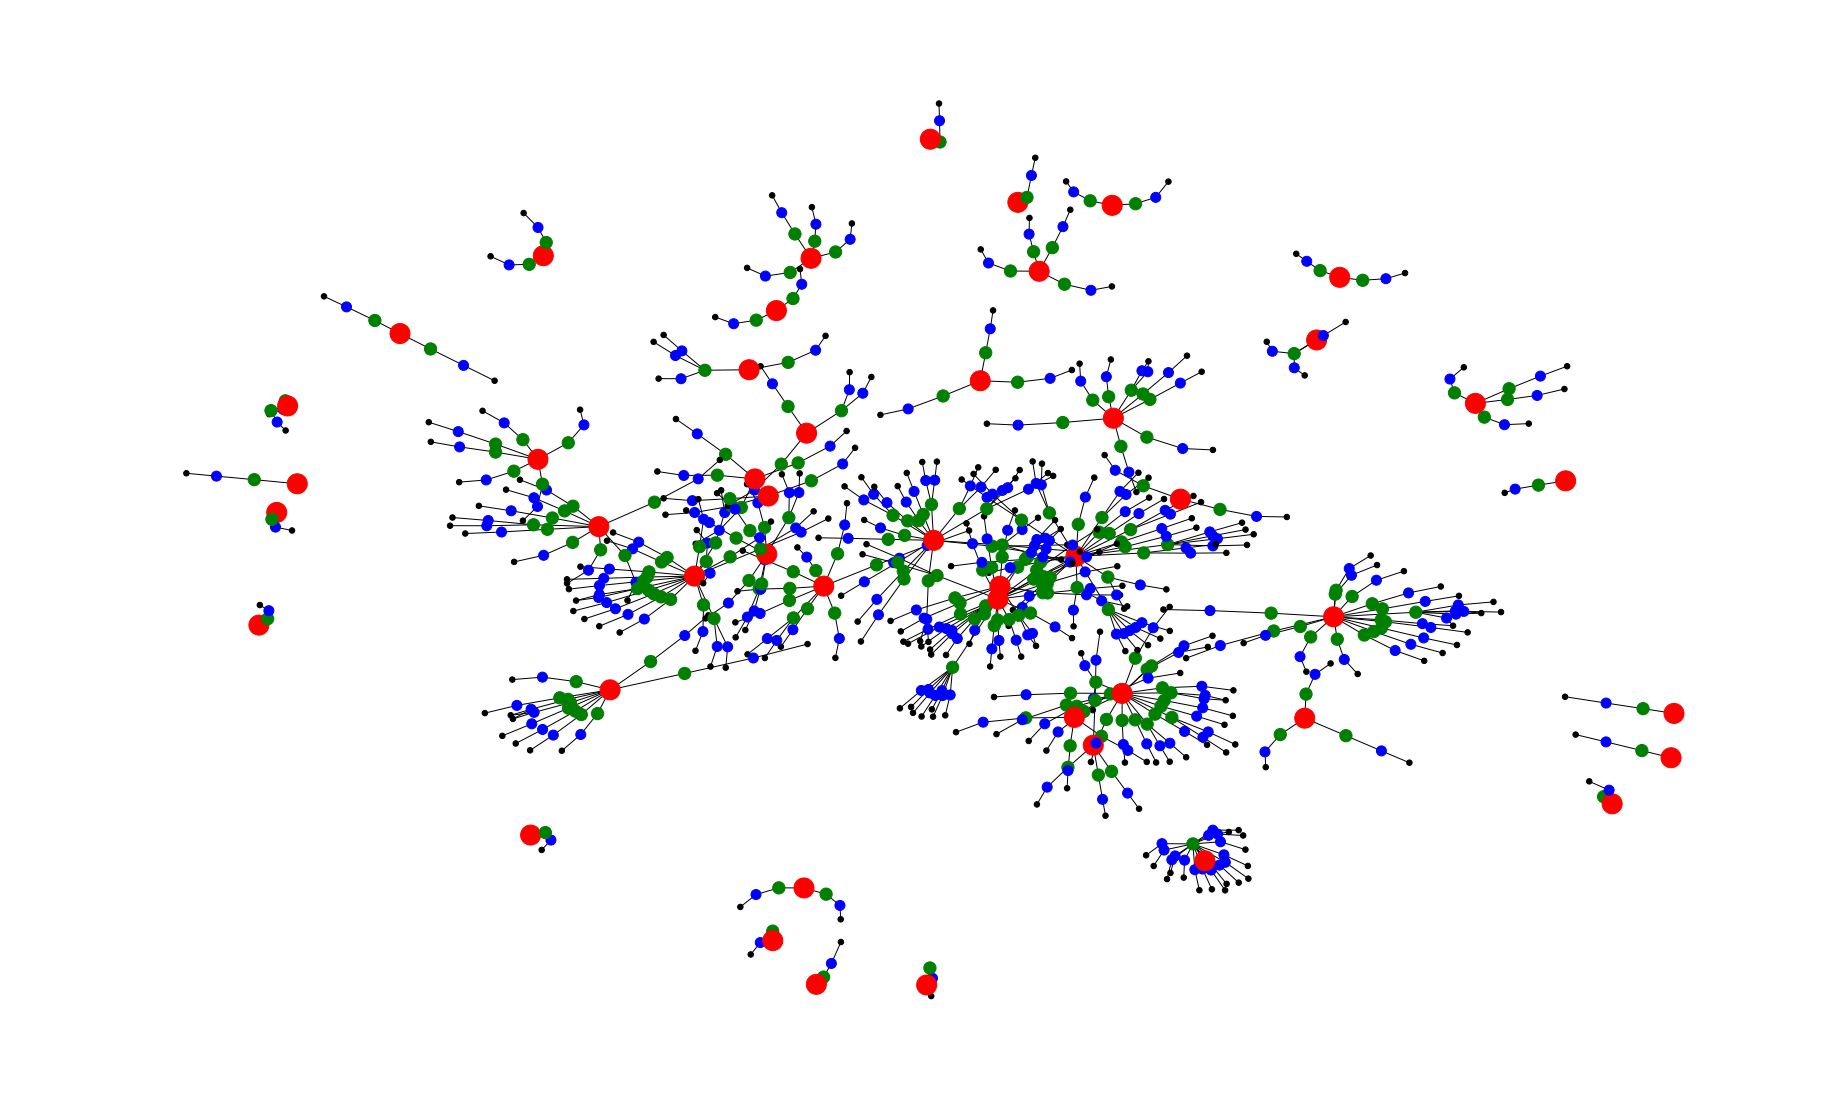

In [40]:
plt.figure(figsize=(25, 15))
nx.draw(G, node_color=cols, node_size=size)
plt.show()

We have the Network

does issue typically have 1 pull request?
what are characteristics of the pull requests that get accepted

pull request gets accept and closes issue
pull request gets accept and doesnt close issue

- percentage of forks that become a pull request
how long it takes for it to become a pull request

what makes a pull request successful, shorter txt? fewer comments?
normalize comments for how how long issue open, look certain words?

Textblob python package

check a repo with lots of issues
check the desccription (like documents) of the issue

TF-IDF

see what words are important per repo, and try to generlize
see which ones are similar

clusters of similar issues have simlar behaviro in pull requests (forks)
what clusters have good / bad pull request?

----------------

cluster for issue and labels
Jaccaid distance

In [115]:
fork_min = forks_pr['fork_counts'].min()
fork_max = forks_pr['fork_counts'].max()
forks_pr['forks_counts_normalized'] = (forks_pr['fork_counts'] - fork_min) / (fork_max - fork_min)

pr_min = forks_pr['pull_request_count'].min()
pr_max = forks_pr['pull_request_count'].max()
forks_pr['pr_counts_normalized'] = (forks_pr['pull_request_count'] - pr_min) / (pr_max - pr_min)

## Grouping fork counts and date difference into categories

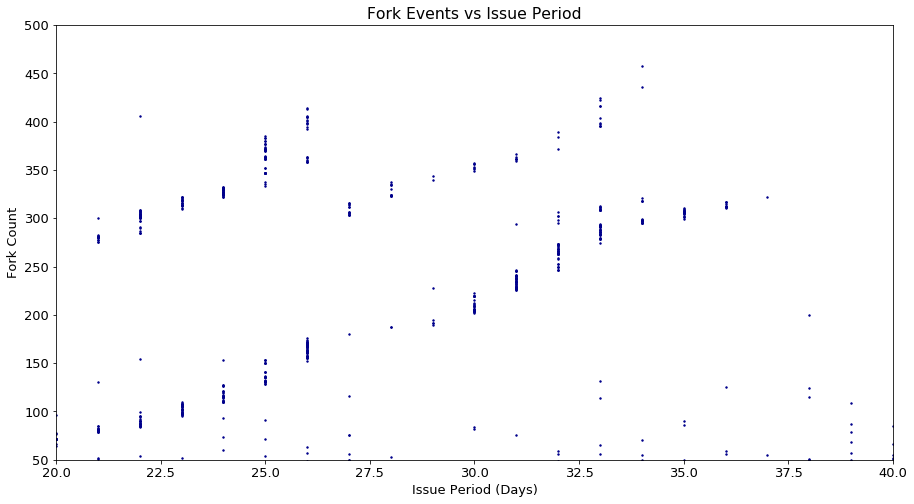

In [178]:
plt.rc('font', size=13)
plt.figure(figsize=(15, 8))
plt.scatter(issues_forks['date_diff'], issues_forks['fork_count'], color='darkblue', s=2)
plt.xlim(20, 40)
plt.ylim(50, 500)
plt.title('Fork Events vs Issue Period')
plt.xlabel('Issue Period (Days)')
plt.ylabel('Fork Count')
plt.show()

Lets get some basic summary statistics on each of the variables

In [ ]:
pull requests
- repo that made the pull request and user
- the time
- the number of comments
- final status of pull requests

In [199]:
# for each group, sort the date_diff and fork_count
for idx, repo in enumerate(sub_groups):
    sub_groups[idx] = sub_groups[idx].sort_values(by=['date_diff', 'fork_count'], ascending=[True, False])

### Which issues have the least differnce with many forks?

In [15]:
groups = split(issue_forks, 'repo_id')

In [16]:
groups[0]

,repo_id,issue_id,issue_number,date_opened,date_closed,date_diff,title,description,labels,url,comments_count,fork_count
5126,58052865,153904548,1,2016-05-10 01:20:39,2016-05-26 07:29:10,16.26,Upload and download progresss support,- [x] Android implementation\r\n- [x] IOS impl...,enhancement,https://github.com/wkh237/react-native-fetch-b...,0,0
5127,58052865,153904858,2,2016-05-10 01:23:52,2016-05-30 15:53:10,20.60,Save downloaded blob data to file system directly,The module now transforms downloaded data into...,enhancement,https://github.com/wkh237/react-native-fetch-b...,0,1
5128,58052865,155418368,3,2016-05-18 05:17:30,2016-05-30 07:06:17,12.08,Support upload file(s) from file path,- [x] Android implementation\r\n- [x] IOS impl...,enhancement,https://github.com/wkh237/react-native-fetch-b...,0,1
5129,58052865,155492914,4,2016-05-18 12:48:52,2016-05-18 13:02:09,0.01,Undefined error,"Hi,\r\n\r\nI wan't to use your package for fet...",,https://github.com/wkh237/react-native-fetch-b...,1,0
5130,58052865,155654587,5,2016-05-19 05:01:33,2016-05-19 09:20:34,0.18,react-native probably not support atob function,,duplicate,https://github.com/wkh237/react-native-fetch-b...,1,0
5131,58052865,155666455,6,2016-05-19 06:56:30,2016-05-19 09:20:34,0.10,go into error except in chrome debugging,I use fetch to post a base64 image data and al...,bug,https://github.com/wkh237/react-native-fetch-b...,4,0
5132,58052865,156089650,7,2016-05-21 07:49:24,2016-05-22 07:59:18,1.01,upload doesn't work,"I'm getting the error:\r\n\r\n```\r\nsorry, th...",,https://github.com/wkh237/react-native-fetch-b...,3,0
5133,58052865,156110520,8,2016-05-21 16:38:22,2016-06-05 08:28:56,14.66,Integration test,- [x] octet-stream upload \r\n- [x] octet-stre...,enhancement,https://github.com/wkh237/react-native-fetch-b...,1,1
5134,58052865,156187859,9,2016-05-23 02:08:39,2016-05-23 03:15:58,0.05,[Android] Incorrect file extension on Android ...,When post/put `multipar/form-data` with androi...,Android::bug,https://github.com/wkh237/react-native-fetch-b...,0,0
5135,58052865,156188099,10,2016-05-23 02:12:20,2016-05-23 03:15:18,0.04,[Android] Error when header is null,"Header is an optional argument, this is a bug.",bug,https://github.com/wkh237/react-native-fetch-b...,0,0


In [18]:
groups[94]

,repo_id,issue_id,issue_number,date_opened,date_closed,date_diff,title,description,labels,url,comments_count,fork_count
9405,67361765,225551715,308,2017-05-01 23:17:01,2017-05-02 15:23:39,0.67,Onblur callback lacking editorState,Here is the gist of what I'm trying to do in m...,,https://github.com/jpuri/react-draft-wysiwyg/i...,1,2
9304,67361765,191594147,78,2016-11-24 21:41:50,2016-11-25 21:55:42,1.01,> sign added when embed something.,I added youtube in your demo.\r\n![chrome_2016...,,https://github.com/jpuri/react-draft-wysiwyg/i...,5,2
9302,67361765,191279016,74,2016-11-23 14:06:00,2016-11-24 18:48:08,1.20,Allow user to configure RTL,,enhancement,https://github.com/jpuri/react-draft-wysiwyg/i...,2,8
9379,67361765,215931252,256,2017-03-22 02:00:30,2017-03-23 10:40:45,1.36,Clicking on image upload box does not open fil...,I try to click on Image upload box which does ...,,https://github.com/jpuri/react-draft-wysiwyg/i...,5,2
9387,67361765,218133311,268,2017-03-30 09:23:41,2017-04-01 05:37:33,1.84,Why I cannot use the method of file upload?,"Hi, \r\nI have using the configuration code, b...",,https://github.com/jpuri/react-draft-wysiwyg/i...,3,2
9301,67361765,191223283,73,2016-11-23 09:36:12,2016-11-25 07:12:27,1.90,How to use spellcheck?,The spellcheck does not work annymore in your ...,enhancement,https://github.com/jpuri/react-draft-wysiwyg/i...,3,11
9406,67361765,227127219,317,2017-05-08 18:08:14,2017-05-10 18:57:22,2.03,Text color is lost after converting raw conten...,"I typed ""this is very interesting thing"" and m...",,https://github.com/jpuri/react-draft-wysiwyg/i...,1,2
9377,67361765,215361549,253,2017-03-20 09:10:04,2017-03-22 15:54:32,2.28,"V1.8.0 font family placeholder is ""PingFang SC""","V1.8.0 font family placeholder is ""PingFang SC...",,https://github.com/jpuri/react-draft-wysiwyg/i...,6,2
9365,67361765,206218706,204,2017-02-08 14:47:50,2017-02-11 00:37:16,2.41,Uncaught TypeError: editorState.getImmutable i...,I've got this error whenever I issued any acti...,,https://github.com/jpuri/react-draft-wysiwyg/i...,9,3
9404,67361765,224693402,306,2017-04-27 07:21:40,2017-04-29 17:29:54,2.42,warning in console,`Warning: Failed prop type: Calling PropTypes ...,,https://github.com/jpuri/react-draft-wysiwyg/i...,4,2


## Of those forks that occured in that time period, how many of the forkees contributed to their version of the fork?

## Using the labels of the issues, whats the count distribution of forks?

In [17]:
query = '''
SELECT DATE(created_at) AS created_at, forked_from, COUNT(*) fork_count
FROM repos 
WHERE forked_from IN (SELECT repo_id 
                      FROM repos
                      WHERE forked_from IS NULL)
GROUP BY DATE(created_at), forked_from;'''

tbl = pd.read_sql(query, con)

In [19]:
tbl['created_at'] = pd.to_datetime(tbl.created_at)
tbl = tbl.set_index('created_at')
tbl_piv = tbl.pivot(columns='forked_from', values='fork_count')

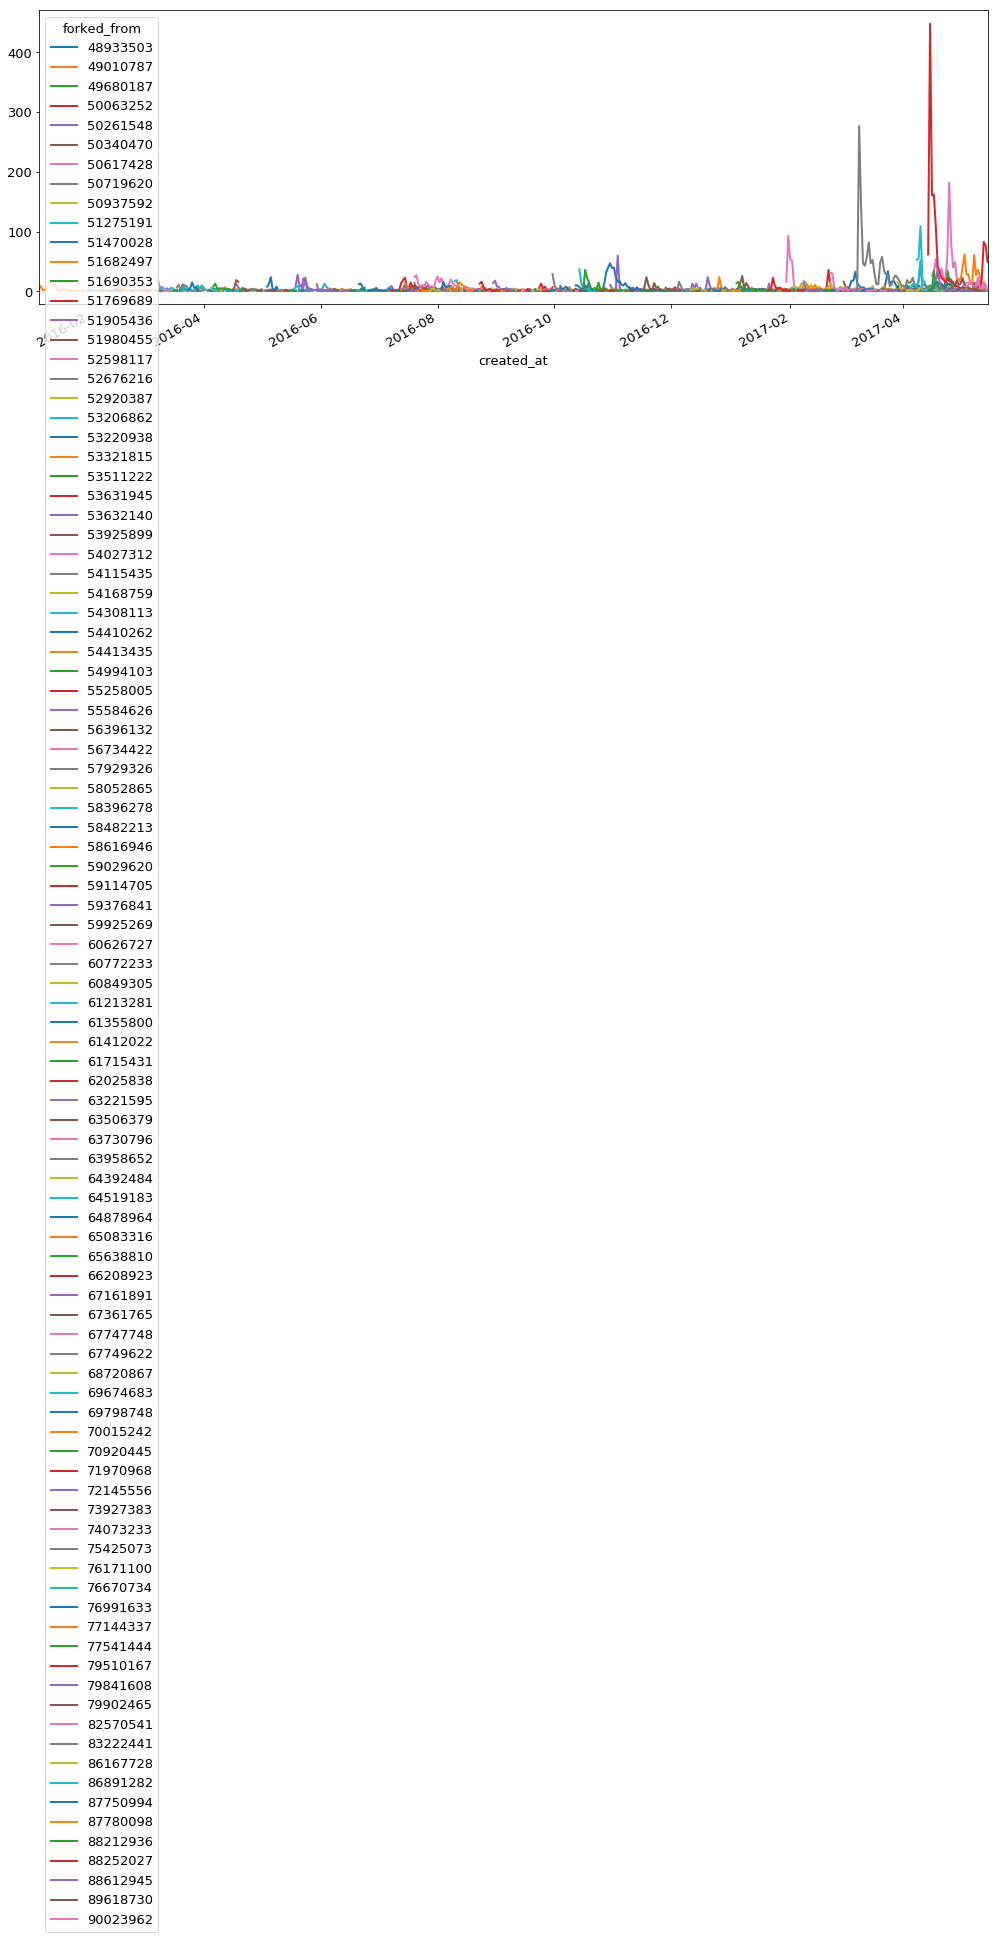

In [29]:
plt.rc('font', size=13)
tbl_piv.plot(figsize=(17, 6), linewidth=2.0)
plt.show()

In [49]:
# Find root repos where the count of forks is not equal to their fork count

query = '''
SELECT repo_id, fork_count AS fork_count_listed, fork_count_counted, ABS(fork_count - fork_count_counted) AS diff
FROM repos
LEFT JOIN (
        SELECT forked_from, COUNT(*) AS fork_count_counted
        FROM repos
        WHERE forked_from IN (SELECT repo_id FROM repos WHERE forked_from IS NULL)
        GROUP BY forked_from
    ) AS R1
ON repo_id = R1.forked_from
WHERE repos.forked_from IS NULL;
'''

pd.read_sql(query, con)


,repo_id,fork_count_listed,fork_count_counted,diff
0,48933503,120,118,2
1,49010787,246,235,11
2,49680187,178,175,3
3,50063252,353,347,6
4,50261548,609,502,107
5,50340470,271,266,5
6,50617428,120,119,1
7,50719620,112,111,1
8,50937592,851,852,1
9,51275191,105,104,1


In [78]:
# How many owners of forked repos made some contribution?

query = '''
SELECT forked_from, COUNT(*) AS contribution_count
  FROM repos
 WHERE owner_id IN (
           SELECT contributor_id
             FROM contributors
       )
AND forked_from IS NOT NULL
GROUP BY forked_from
HAVING COUNT(*) > 1;
'''

pd.read_sql(query, con)

,forked_from,contribution_count
0,48933503,13
1,49010787,16
2,49680187,13
3,50063252,94
4,50261548,222
5,50340470,22
6,50617428,21
7,50719620,11
8,50937592,53
9,51275191,12
